# Proceso  de EDA para estudiar los datos, y preparacion para hacer un modelo de recomendacion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split as train_test_splitSV
from sklearn.preprocessing import LabelEncoder
import pickle
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from sklearn.pipeline import Pipeline



## Steam Games

In [2]:
steam_games = pd.read_csv('./datasets/steam_games.csv')

In [34]:
steam_games['Year']

0        2018.0
1        2018.0
2        2017.0
3        2017.0
4        2018.0
          ...  
27829    2018.0
27830    2018.0
27831    2018.0
27832    2018.0
27833    2017.0
Name: Year, Length: 27834, dtype: float64

In [35]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27834 entries, 0 to 27833
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   app_name                   27834 non-null  object 
 1   release_date               27774 non-null  object 
 2   price                      27834 non-null  float64
 3   id                         27834 non-null  int64  
 4   developer                  27834 non-null  object 
 5   Accounting                 27834 non-null  int64  
 6   Action                     27834 non-null  int64  
 7   Adventure                  27834 non-null  int64  
 8   Animation &amp; Modeling   27834 non-null  int64  
 9   Audio Production           27834 non-null  int64  
 10  Casual                     27834 non-null  int64  
 11  Design &amp; Illustration  27834 non-null  int64  
 12  Early Access               27834 non-null  int64  
 13  Education                  27834 non-null  int

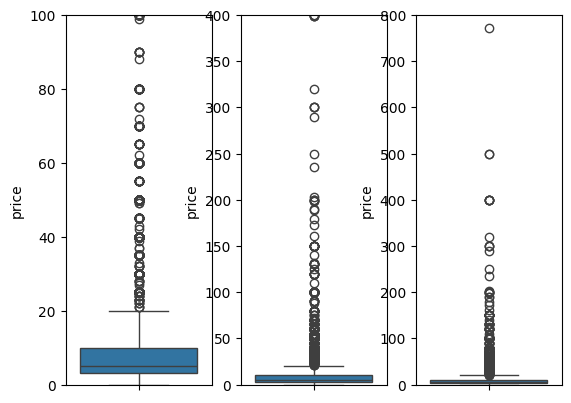

In [36]:
fig,ax = plt.subplots(1,3)
sns.boxplot(data=steam_games,y='price',ax = ax[0])
sns.boxplot(data=steam_games,y='price',ax = ax[1])
sns.boxplot(data=steam_games,y='price',ax = ax[2])
ax[0].set_ylim(0,100)
ax[1].set_ylim(0,400)
ax[2].set_ylim(0,800)
plt.show()

### En el grafico se puede ver que la columna price tiene muchos valores atipicos que superan los 20 y llegan a los 1000, sin embargo en una app de juegos es posible tener tal distribucion, es decir muchos juegos de precio bajo y varios de precio alto por esto no se hara un tratado especial

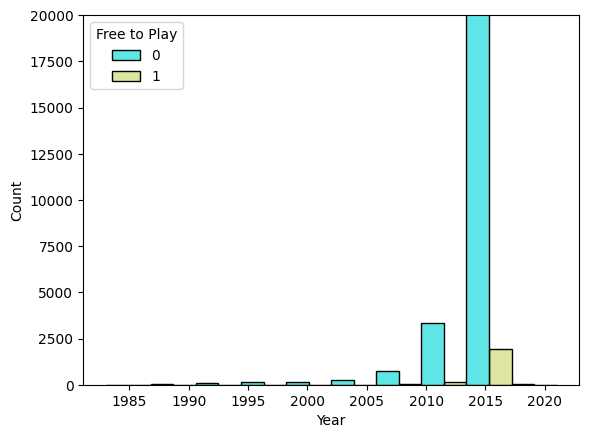

In [37]:
sns.histplot(data=steam_games,x='Year',hue='Free to Play',bins=10,palette='rainbow',multiple='dodge')

plt.ylim(0,20000)
plt.show()

### 2015 es el año con mas juegos y mas juegos Free To Play

## Users Reviews

In [38]:
user_review = pd.read_csv('./datasets/user_reviews.csv')

In [39]:
user_review.sample(5)

,user_id,posted,item_id,recommend,sentiment_analysis
53791,51jets,"Posted January 16, 2015.",730,True,2
26786,grutten,"Posted December 19, 2014.",204360,True,2
30006,UnkleFisty,"Posted December 12, 2015.",265890,True,2
53102,paulspeltwithap,"Posted July 1, 2015.",205100,True,2
33801,Hawwwk,"Posted December 16, 2014.",322330,True,1


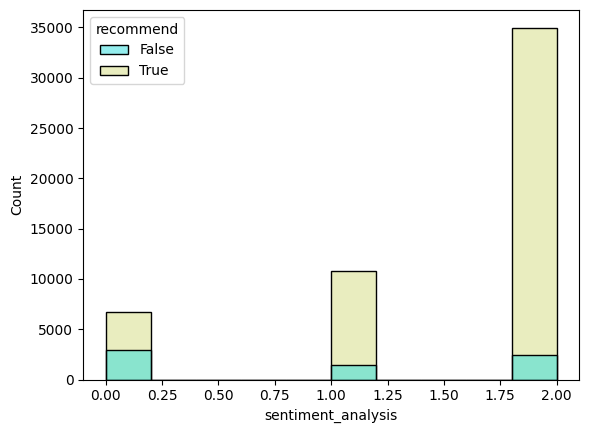

In [40]:
sns.histplot(data=user_review,x='sentiment_analysis',bins=10,palette='rainbow',hue='recommend')

plt.show()

### Como se ve del total de sentimiento malos, un alto porcentaje son recomendaciones falsas, y de los buenos el total de recomendaciones true son altas, Para ambas hay un porcentaje existente de recomendaciones que parecen opuesta al sentimiento

## Users Items

In [3]:
with gzip.open('datasets/user_items_proc.csv.gz', 'rb') as f:
    user_items_proc = pd.read_csv(f, encoding='utf-8')

In [42]:
user_items_proc.sample(5)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
3860084,TheAussieBeast,1049,76561197970884763,http://steamcommunity.com/id/TheAussieBeast,207080.0,Indie Game: The Movie,75.0,0.0
4773590,76561198071602712,187,76561198071602712,http://steamcommunity.com/profiles/76561198071...,32430.0,STAR WARS‚Ñ¢: The Force Unleashed‚Ñ¢ Ultimate ...,272.0,0.0
4347195,76561198045040276,95,76561198045040276,http://steamcommunity.com/profiles/76561198045...,367540.0,Starbound - Unstable,0.0,0.0
4236952,lisforlove13,44,76561198038907267,http://steamcommunity.com/id/lisforlove13,204880.0,Sins of a Solar Empire: Rebellion,23.0,0.0
2700065,Macman179,140,76561198052845873,http://steamcommunity.com/id/Macman179,202990.0,Call of Duty: Black Ops II - Multiplayer,392.0,0.0


In [43]:
user_items_proc['item_id'].nunique()

10978

In [3]:
user_items_proc['playtime_forever'].describe()

count    5.153209e+06
mean     9.914951e+02
std      5.418204e+03
min      0.000000e+00
25%      0.000000e+00
50%      3.400000e+01
75%      3.550000e+02
max      6.427730e+05
Name: playtime_forever, dtype: float64

In [6]:
user_items_proc['playtime_forever'].idxmax()
id = user_items_proc.iloc[587715]['item_id']
steam_games[steam_games['id'] == id]['Year']


38    2006.0
Name: Year, dtype: float64

<Axes: ylabel='playtime_forever'>

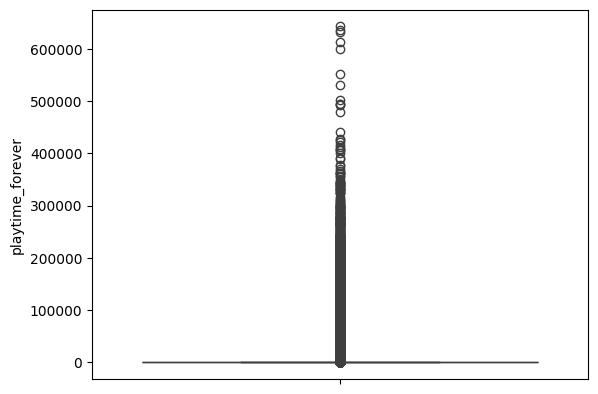

In [44]:
sns.boxplot(data=user_items_proc,y='playtime_forever')


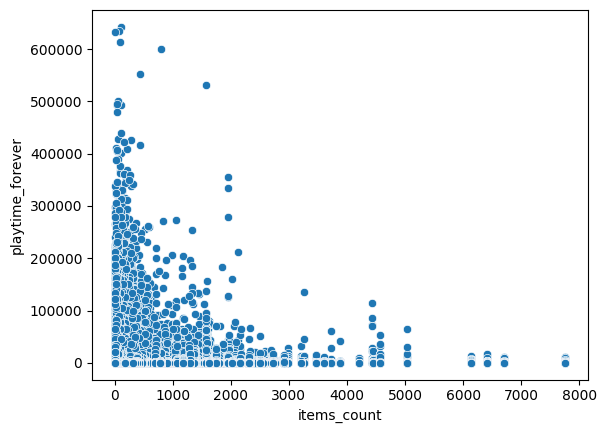

In [45]:
sns.scatterplot(data=user_items_proc,x='items_count',y='playtime_forever')
plt.show()

### Se podria analisar de forma que a menos cantidad de items mas tiempo consume un usuario un juego especifico.

# Modelo de recomendacion

### Cargo el dataset usado para el modelo

In [2]:
user_reviews = pd.read_csv('./datasets/user_reviews.csv',usecols=['user_id','item_id','sentiment_analysis','recommend'])
label_encoder = LabelEncoder()
#elimino la columna user_id
user_reviews['user_id_num'] = label_encoder.fit_transform(user_reviews['user_id'])
user_reviews['rating'] = np.where(user_reviews['recommend'] == True,1 + user_reviews['sentiment_analysis'],user_reviews['sentiment_analysis']-1)


### Genero id numericos para user_id usando label encoder

In [6]:
reader = Reader(rating_scale=(-1,3))
data = Dataset.load_from_df(user_reviews[['user_id_num','item_id','rating']], reader)


### Separo el dataset en entrenamiento y testeo

In [7]:
train,test = train_test_splitSV(data,test_size = .25)

## Voy a usar un modelo De descomposicion en valor singular (SVD), el cual es un filtro colaborativo
### Voy a usar los datos de 
* user_id
* item_id
* sentiment_analysis: como rating

In [8]:
model = SVD()

### Aplico GridSearch para encontrar al modelo con los mejores hiperparametros

In [9]:
param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [10]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
best_model = gs.best_estimator['rmse']

1.0603279743825886
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


### Veo que el modelo tiene un rmse de 0.74 lo cual esta cerca de 1
### Ademas veo los mejores hiperparametros

## Por ultimo defino el modelo con los mejores hiperparametros y lo exporto

In [11]:
model = SVD(n_factors=5,n_epochs=20,lr_all=0.005,reg_all=0.2)
model.fit(train)

In [12]:
from surprise import accuracy
train_predictions = model.test(train.build_testset())
test_predictions = model.test(test)
print(f"RMSE en el conjunto de entrenamiento: {accuracy.rmse(train_predictions)}")
print(f"RMSE en el conjunto de prueba: {accuracy.rmse(test_predictions)}")

RMSE: 0.9432
RMSE en el conjunto de entrenamiento: 0.9432279996788621
RMSE: 1.0496
RMSE en el conjunto de prueba: 1.049628350446055


### EL modelo obtuvo un mejor rendimiento en los datos de testeo

In [13]:
with open('./model/SVD_model.pkl', 'wb') as file: # Exporto mi modelo
    pickle.dump(model, file)